In [98]:
import os
from paris.models import Match
from paris.module_data import FeaturesBuilder, parse_team_name
from paris.utils import AutoBettor
import pandas as pd

import datetime
import pytz
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline 
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

## Import matches

In [100]:
matches = pd.DataFrame(list(Match.objects.filter(
    status='Results', date__lte=datetime.datetime(2020, 10, 1, tzinfo=pytz.utc)).values()))

In [101]:
FB = FeaturesBuilder()

In [102]:
features = FB.get_features(matches,target=True)

One or both teams not in the ranking : ['nextp', 'xpc']
One or both teams not in the ranking : ['igg', 'cool']
One or both teams not in the ranking : ['agg', 'e-frag']
One or both teams not in the ranking : ['physx', 'igg']
One or both teams not in the ranking : ['igg', 'cool']
One or both teams not in the ranking : ['nextp', 'xpc']
One or both teams not in the ranking : ['igg', 'nextp']
One or both teams not in the ranking : ['xpc', 'nextp']
One or both teams not in the ranking : ['dendd', 'agg']
One or both teams not in the ranking : ['dendd', 'agg']
One or both teams not in the ranking : ['agg', 'dendd']
One or both teams not in the ranking : ['dreams', 'mith']
One or both teams not in the ranking : ['usa fe', 'ldlc.fe']
One or both teams not in the ranking : ['ldlc.fe', 'expert.fem']
One or both teams not in the ranking : ['mith', 'dreams']
One or both teams not in the ranking : ['alternate attax', 'elements']
One or both teams not in the ranking : ['qb fire', 'elements']
One or bo

              team1            team2  odd1   odd2                      date  \
8           godsent             ence  1.36   3.27 2016-05-14 17:45:00+00:00   
17         bluejays  alternate attax  3.11   1.38 2016-12-12 21:00:00+00:00   
20             envy          teamone  1.07  11.84 2017-01-13 13:05:00+00:00   
30              big          godsent  2.03   1.79 2017-05-14 14:55:00+00:00   
33             mibr      singularity  1.15   6.44 2017-06-17 11:00:00+00:00   
...             ...              ...   ...    ...                       ...   
3532     myinsanity     red instinct  7.16   1.13 2020-09-30 18:00:00+00:00   
3533   wisla krakow           secret  1.89   1.91 2020-09-30 18:45:00+00:00   
3534    mousesports             ence  1.58   2.39 2020-09-30 19:05:00+00:00   
3535             9z             keyd  1.42   2.93 2020-09-30 19:20:00+00:00   
3536  real betis sa           e-galo  3.04   1.40 2020-09-30 21:50:00+00:00   

                                                  l

## Different strategies

### The benchmark
The most naive strategy is just following the prediction of the bookmaker, and betting on the lowest odds. Let's analyze the outcome of such strategy.

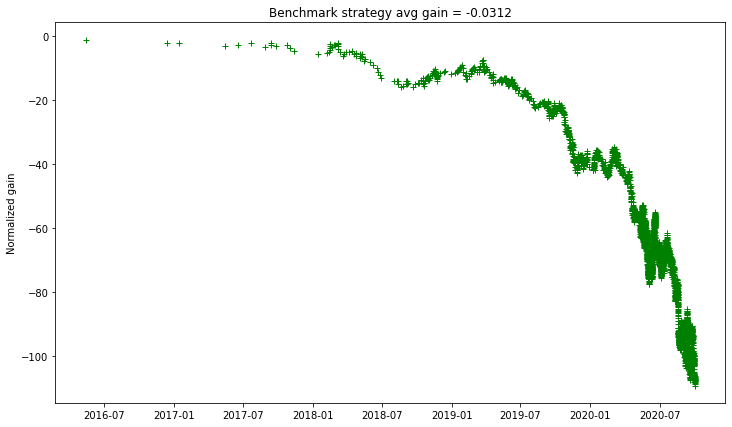

In [103]:
odd1 = features.loc[:, 'odd1']
odd2 = features.loc[:, 'odd2']
y = features.loc[:, 'y']
dates = features.loc[:,'date']
m = 1  # bet 1€
decision = odd1 < odd2
gain = np.array((decision *
        (y * (odd1-1) - (1-y))
        +
        (1 - decision) *
        ((1-y) * (odd2 - 1) - y)))
gain_cumulative = gain.copy()
for i in range(1,len(gain)):
    gain_cumulative[i] += gain_cumulative[i-1]

plt.figure(figsize=(12,7))
plt.title(f'Benchmark strategy avg gain = {gain.mean():.3}')
plt.ylabel('Normalized gain')
plt.plot(dates,gain_cumulative,'g+')
plt.show()

This strategy is very bad, and it is because the bookmaker has a margin. We can estimate this margin by the average loss, here around $3$% of the bet.

### Logreg

The logistic regression is quite a basic model, compared to some complicated deep neural networks or gradient boosting. But it has the good property of providing good estimation of probabilities, and not only targets. See https://scikit-learn.org/stable/modules/calibration.html.

In [195]:
x_train, x_test, y_train, y_test = train_test_split(
    features.drop('y', axis=1), features['y'], test_size=0.3, shuffle=False)

In [196]:
col_trans = make_column_transformer(['drop', 'date'],
                                    remainder='passthrough')
clf = LogisticRegression()
pipeline = make_pipeline(
    (col_trans),
    (clf)
)

In [197]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop', 'date')])),
                ('logisticregression', LogisticRegression())])

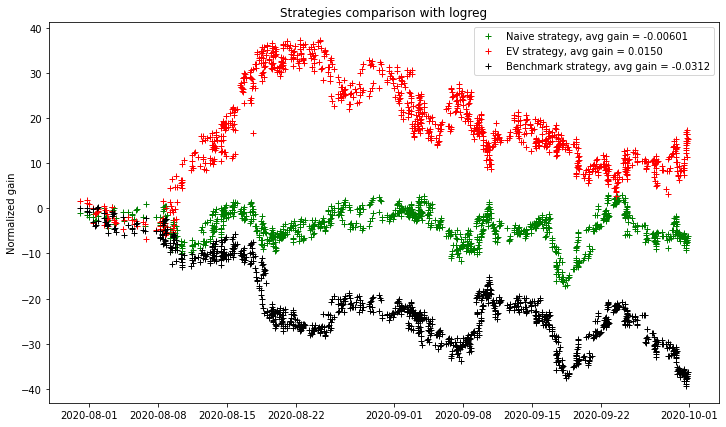

In [198]:
y_pred = pipeline.predict(x_test)
odd1 = x_test.loc[:, 'odd1']
odd2 = x_test.loc[:, 'odd2']
y = y_test
dates = x_test.loc[:, 'date']
m = 1  # bet 1€

decision_naive = y_pred
gain_naive = np.array((decision_naive *
                       (y * (odd1-1) - (1-y))
                       +
                       (1 - decision_naive) *
                       ((1-y) * (odd2 - 1) - y)))
gain_cumulative_naive = gain_naive.copy()
for i in range(1, len(gain_naive)):
    gain_cumulative_naive[i] += gain_cumulative_naive[i-1]

probas = pipeline.predict_proba(x_test)
p1 = probas[:, 1]
p2 = probas[:, 0]


def f_decision_ev(p1, p2, odd1, odd2):
    """
    We bet on 1 if EV1 > EV2 and EV1 > 0 (decision = 1)
    We bet on 0 if EV2 > EV1 and EV2 > 0 (decision = -1)
    We don't bet in other cases.
    """
    p1o1 = p1 * odd1.astype(float) - 1
    p2o2 = p2 * odd2.astype(float) - 1
    y = np.zeros(len(p1))
    y += ((p1o1 > p2o2) & (p1o1) > 0).astype(int)
    y -= ((p1o1 < p2o2) & (p2o2) > 0).astype(int)
    return y


decision_ev = f_decision_ev(p1, p2, odd1, odd2)
gain_ev = np.array(((decision_ev == 1) *
                    (y * (odd1-1) - (1-y))
                    +
                    (decision_ev == -1) *
                    ((1-y) * (odd2 - 1) - y)))
gain_cumulative_ev = gain_ev.copy()
for i in range(1, len(gain_ev)):
    gain_cumulative_ev[i] += gain_cumulative_ev[i-1]

plt.figure(figsize=(12, 7))
plt.title(f'Strategies comparison with logreg')
plt.ylabel('Normalized gain')
plt.plot(dates, gain_cumulative_naive, 'g+',
         label=f'Naive strategy, avg gain = {gain_naive.mean():.3}')
plt.plot(dates, gain_cumulative_ev, 'r+',
         label=f'EV strategy, avg gain = {gain_ev.mean():.3}')
plt.plot(dates, gain_cumulative[-len(x_test):] -
         gain_cumulative[-len(x_test)], 'k+',
         label=f'Benchmark strategy, avg gain = {gain.mean():.3}')


plt.legend()
plt.show()

It turns out that our simple decision rule based on expected value is working pretty well, on this example we have an edge large enough to beat the bookmaker. Note that here we bet $m=1$ at each bet, without taking into consideration the size of our bankroll.

### Kelly criterion
Now we consider we have a finite bankroll of size $B$ and we cant to bet only $f = \frac {edge} {odd} B $ for each match.

In [199]:
B = [50]
gain_ev_kelly = gain_ev.copy()
for i in range(len(decision_ev)):
    dec = decision_ev.iloc[i]
    f = ((dec == 1) * (float(odd1.iloc[i]) * p1[i]-1)/float(odd1.iloc[i]) +
        (dec == -1) * (float(odd2.iloc[i]) * p2[i]-1)/float(odd2.iloc[i]))
    gain_ev_kelly[i] = f * B[i]* ((dec == 1) *
                    (y.iloc[i] * (float(odd1.iloc[i])-1) - (1-y.iloc[i]))
                    +
                    (dec == -1) * 
                    ((1-y.iloc[i]) * (float(odd2.iloc[i]) - 1) - y.iloc[i]))
    B.append(B[i]+gain_ev_kelly[i])


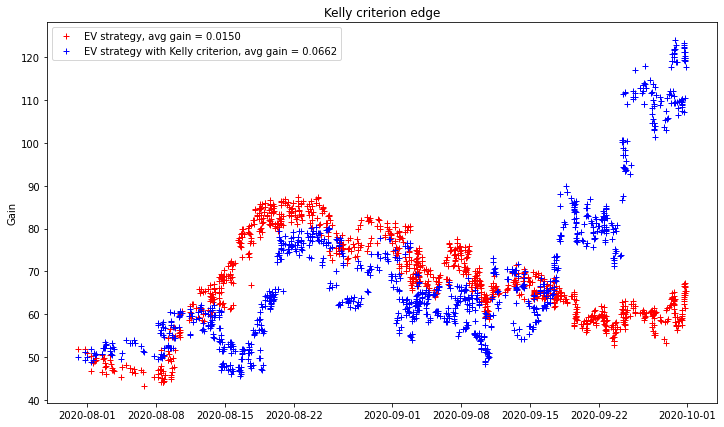

In [200]:

plt.figure(figsize=(12, 7))
plt.title(f'Kelly criterion edge')
plt.ylabel('Gain')

plt.plot(dates, gain_cumulative_ev +50, 'r+',
         label=f'EV strategy, avg gain = {gain_ev.mean():.3}')
plt.plot(dates, B[:-1], 'b+',
         label=f'EV strategy with Kelly criterion, avg gain = {gain_ev_kelly.mean():.3}')


plt.legend()
plt.show()